In [ ]:
%pip install -q langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install langchain langchain-google-genai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 32.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.74
    Uninstalling langchain-core-0.3.74:
      Successfully uninstalled langchain-core-0.3.74
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
import pandas as pd
import smtplib
import datetime
import random
import uuid



In [ ]:
from typing import TypedDict,List,Dict,Any,Optional
import os
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.messages import HumanMessage


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="models/gemini-2.0-flash",
    temperature=0,
    google_api_key=""
)

In [ ]:
class AgentState(TypedDict):
    # Basic patient info
    name: Optional[str]
    dob: Optional[str]          # date of birth
    doctor: Optional[str]
    location: Optional[str]

    # Appointment details
    is_new_patient: Optional[bool]
    appointment_time: Optional[str]
    appointment_id: Optional[str]

    # Insurance details
    insurance_carrier: Optional[str]
    insurance_member_id: Optional[str]
    insurance_group: Optional[str]

    # Status flags
    confirmation_status: Optional[str]   # e.g., "pending", "confirmed", "cancelled"
    reminder_sent: Optional[int]         # how many reminders sent so far

In [ ]:
from datetime import datetime

# Greet Node
def greet_patient(state: AgentState) -> AgentState:
    user_msg = f"My name is {state['name']}, DOB {state['dob']}, from {state['location']}."

    response = model.invoke([HumanMessage(content=f"""
    A patient is starting an appointment request.
    Info: {user_msg}.
    Write a short friendly greeting to welcome them to the clinic.
    """)])

    print(" LLM Greeting:", response.content)
    return state

# Lookup Patient Node


def lookup_patient(state: AgentState) -> AgentState:
    """
    Reads patients_indian.csv and sets state['is_new_patient'] = True/False
    """
    try:
        patients = pd.read_csv("patients_indian.csv")
    except FileNotFoundError:
        print(" patients_indian.csv not found — assuming new patient.")
        state["is_new_patient"] = True
        return state

    name = state.get("name")
    dob  = state.get("dob")

    # Simple robust matching (strip + lower)
    match = patients[
        (patients["name"].str.strip().str.lower() == (name or "").strip().lower()) &
        (patients["dob"].astype(str).str.strip() == str(dob).strip())
    ]

    if not match.empty:
        state["is_new_patient"] = False
        print(f" Returning patient detected: {name}")
    else:
        state["is_new_patient"] = True
        print(f" New patient: {name}")

    return state


# Scheduling Node
import pandas as pd
from datetime import datetime

def schedule_appointment(state: AgentState) -> AgentState:
    """
    - Picks first available slot
    - Sets appointment length: 60 if new patient else 30
    - Marks slot as booked in doctor_schedule_indian.xlsx with appointment metadata
    """
    try:
        df = pd.read_excel("doctor_schedule_indian.xlsx")
    except FileNotFoundError:
        print(" doctor_schedule_indian.xlsx not found. Create it first.")
        state["confirmation_status"] = "no_schedule_file"
        return state

    # Ensure columns exist
    if "status" not in df.columns:
        df["status"] = "free"
    if "booked_by" not in df.columns:
        df["booked_by"] = None
    if "appointment_id" not in df.columns:
        df["appointment_id"] = None
    if "appointment_length" not in df.columns:
        df["appointment_length"] = None

    # Determine needed duration
    is_new = state.get("is_new_patient")
    if is_new is None:
        # fallback: assume new
        is_new = True
        state["is_new_patient"] = True

    duration = 60 if is_new else 30
    state["appointment_length"] = duration

    # Find first free slot
    free_slots = df[df["status"] == "free"]
    if free_slots.empty:
        print(" No available slots found.")
        state["confirmation_status"] = "no_slot"
        return state

    slot_idx = free_slots.index[0]
    slot = df.at[slot_idx, "slot"]
    doctor = df.at[slot_idx, "doctor"]

    appointment_id = f"APT-{datetime.now().strftime('%Y%m%d%H%M%S')}"

    # Book the slot
    df.at[slot_idx, "status"] = "booked"
    df.at[slot_idx, "booked_by"] = state.get("name")
    df.at[slot_idx, "appointment_id"] = appointment_id
    df.at[slot_idx, "appointment_length"] = duration

    # Persist change (Calendly-style file operation)
    df.to_excel("doctor_schedule_indian.xlsx", index=False)

    # Update state
    state["appointment_time"] = slot
    state["doctor"] = doctor
    state["appointment_id"] = appointment_id
    state["confirmation_status"] = "pending"  # will be set to confirmed later

    print(f" Booked: {state.get('name')} with {doctor} at {slot} ({duration} mins). Appointment ID: {appointment_id}")
    return state



# Insurance Node
def collect_insurance(state: AgentState) -> AgentState:
    state["insurance_carrier"] = "Blue Cross"
    state["insurance_member_id"] = "12345"
    state["insurance_group"] = "A1B2"
    print(" Insurance details captured")
    return state

# Confirmation Node
def confirm_appointment(state: AgentState) -> AgentState:
    response = model.invoke([HumanMessage(content=f"""
    Confirm this appointment for patient {state['name']}
    with {state['doctor']} at {state['appointment_time']}.
    Respond in a polite, professional tone.
    """)])

    print(" LLM Confirmation:", response.content)
    state["confirmation_status"] = "confirmed"
    return state

# Form Distribution Node
def send_forms(state: AgentState) -> AgentState:
    patient_name = state.get("name")
    to_email = "demo_patient@example.com"   # replace with patient email

    # Simulate sending email
    print(f" Intake form sent to {to_email} (simulated email).")
    state["forms_sent"] = True
    return state
# Reminder Node
def send_reminders(state: AgentState) -> AgentState:
    """
    Sends/simulates 3 reminders.
    - Reminder 1: simple nudge
    - Reminder 2: ask about forms; if forms not sent, simulate patient action
    - Reminder 3: final check: if not confirmed, simulate confirm or cancel (with reason)
    """
    patient_name = state.get("name")
    to_email = state.get("email", "demo_patient@example.com")  # use real email if present

    # Ensure counters and flags exist
    state["reminder_sent"] = state.get("reminder_sent", 0)
    state["forms_sent"] = state.get("forms_sent", False)
    state["forms_completed"] = state.get("forms_completed", False)
    state["cancellation_reason"] = state.get("cancellation_reason", None)

    # Reminder 1
    state["reminder_sent"] = 1
    print(f" Reminder 1 to {patient_name} ({to_email}): Your appointment is on {state.get('appointment_time')}.")

    # Reminder 2: check forms
    state["reminder_sent"] = 2
    if not state.get("forms_sent", False):
        # Simulate asking patient to complete forms. Simulate response:
        responded = random.random() < 0.7  # 70% chance they complete forms after reminder
        if responded:
            state["forms_sent"] = True
            state["forms_completed"] = True
            print(f" Reminder 2: patient completed intake forms (simulated).")
        else:
            state["forms_sent"] = False
            state["forms_completed"] = False
            print(f" Reminder 2: patient did NOT complete forms after reminder (simulated).")
    else:
        state["forms_completed"] = True
        print(f" Reminder 2: forms were already sent earlier.")

    # Reminder 3: final reminder with confirm/cancel action
    state["reminder_sent"] = 3
    if state.get("confirmation_status") == "confirmed":
        print(f" Reminder 3: already confirmed for {patient_name}. No further action.")
    else:
        # Simulate patient decision: confirm (70%) or cancel (30%)
        confirm = random.random() < 0.7
        if confirm:
            state["confirmation_status"] = "confirmed"
            print(f" Reminder 3: patient confirmed the appointment (simulated).")
        else:
            state["confirmation_status"] = "cancelled"
            # Provide a simulated cancellation reason
            reasons = [
                "Scheduling conflict",
                "Found a closer clinic",
                "Unable to travel",
                "Insurance issue",
                "Feeling better"
            ]
            reason = random.choice(reasons)
            state["cancellation_reason"] = reason
            print(f" Reminder 3: patient cancelled appointment (simulated). Reason: {reason}")

    # timestamp last reminder
    state["last_reminder_at"] = datetime.now().isoformat()

    return state

# Export Report Node
def export_report(state: AgentState) -> AgentState:
    row = {
        "appointment_id": state.get("appointment_id"),
        "name": state.get("name"),
        "dob": state.get("dob"),
        "doctor": state.get("doctor"),
        "slot": state.get("appointment_time"),
        "insurance_carrier": state.get("insurance_carrier"),
        "confirmation_status": state.get("confirmation_status"),
        "reminders_sent": state.get("reminder_sent"),
        "timestamp": datetime.now()
    }

    try:
        report = pd.read_excel("appointments_report.xlsx")
        report = pd.concat([report, pd.DataFrame([row])], ignore_index=True)
    except FileNotFoundError:
        # If file doesn't exist yet, create new one
        report = pd.DataFrame([row])

    report.to_excel("appointments_report.xlsx", index=False)
    print("Report exported to appointments_report.xlsx")

    return state


In [ ]:
graph = StateGraph(AgentState)


In [ ]:
graph.add_node("greet_patient", greet_patient)
graph.add_node("lookup_patient", lookup_patient)
graph.add_node("schedule_appointment", schedule_appointment)
graph.add_node("collect_insurance", collect_insurance)
graph.add_node("confirm_appointment", confirm_appointment)
graph.add_node("send_forms", send_forms)
graph.add_node("send_reminders", send_reminders)
graph.add_node("export_report", export_report)


In [ ]:
graph.add_edge(START, "greet_patient")
graph.add_edge("greet_patient", "lookup_patient")
graph.add_edge("lookup_patient", "schedule_appointment")
graph.add_edge("schedule_appointment", "collect_insurance")
graph.add_edge("collect_insurance", "confirm_appointment")
graph.add_edge("confirm_appointment", "send_forms")
graph.add_edge("send_forms", "send_reminders")
graph.add_edge("send_reminders", "export_report")
graph.add_edge("export_report", END)


In [ ]:
app = graph.compile()


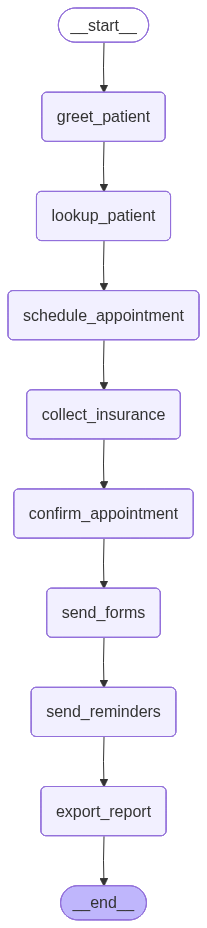

In [ ]:
from IPython.display import Image
display(Image(app.get_graph().draw_mermaid_png()))



In [ ]:
patients = pd.read_csv("/content/patients_indian.csv")
doctor_schedule = pd.read_excel("/content/doctor_schedule_indian.xlsx")


In [ ]:
final_state = app.invoke({
    "name": "Anushka Joshi",
    "dob": "2004-03-20",
    "location": "India"
})

print(final_state)


 LLM Greeting: Welcome, Anushka! We're happy to help you schedule an appointment.
 New patient: Anushka Joshi
 Booked: Anushka Joshi with Dr. Ahuja at 2025-09-04 9:00 (60 mins). Appointment ID: APT-20250903173140
 Insurance details captured
 LLM Confirmation: Subject: Regarding Appointment Confirmation for Anushka Joshi - September 4th

Dear Anushka Joshi,

This email confirms your appointment with Dr. Ahuja on September 4th, 2025, at 9:00 AM.

We look forward to seeing you then. Please do not hesitate to contact us if you have any questions or need to reschedule.

Sincerely,

[Your Name/Clinic Name]
 Intake form sent to demo_patient@example.com (simulated email).
 Reminder 1 to Anushka Joshi (demo_patient@example.com): Your appointment is on 2025-09-04 9:00.
 Reminder 2: patient completed intake forms (simulated).
 Reminder 3: already confirmed for Anushka Joshi. No further action.
Report exported to appointments_report.xlsx
{'name': 'Anushka Joshi', 'dob': '2004-03-20', 'doctor': 'Dr

In [ ]:
from email.message import EmailMessage

def send_forms(state: AgentState) -> AgentState:
    patient_name = state.get("name")
    to_email = "demo_patient@example.com"   # replace with patient email

    msg = EmailMessage()
    msg["From"] = os.environ["EMAIL_USER"]     # set Gmail or other in env vars
    msg["To"] = to_email
    msg["Subject"] = "Your Intake Form"
    msg.set_content(f"Hello {patient_name},\n\nPlease find attached your intake form.")

    # Attach the PDF form
    with open("New Patient Intake Form.pdf", "rb") as f:
        file_data = f.read()
    msg.add_attachment(file_data, maintype="application", subtype="pdf", filename="Intake_Form.pdf")

    # Send email (requires Gmail/Twilio or any SMTP)
    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
        smtp.login(os.environ["EMAIL_USER"], os.environ["EMAIL_PASS"])
        smtp.send_message(msg)

    print(f" Intake form sent to {to_email}")
    state["forms_sent"] = True
    return state


In [ ]:

def send_reminders(state: AgentState) -> AgentState:
    patient_name = state.get("name")
    to_email = "demo_patient@example.com"   # replace with patient email

    reminders = [
        "Reminder 1: Your appointment is coming up.",
        "Reminder 2: Please confirm and complete your intake forms.",
        "Reminder 3: Final reminder. Confirm or cancel your appointment."
    ]

    for idx, reminder in enumerate(reminders, start=1):
        # Simulate email/SMS sending
        print(f" Reminder #{idx} sent to {patient_name}: {reminder}")
        state["reminder_sent"] = idx   # track how many sent

    return state

In [ ]:
final_state = app.invoke({
    "name": "Sanya Iyer",
    "dob": "23-08-1974",
    "location": "India"
})
print(final_state)


 LLM Greeting: Okay, here's a short, friendly greeting for Sanya:

"Hello Sanya, welcome to our clinic! We're happy to help you with your appointment request. It's great to have you with us."
 New patient: Sanya Iyer
 Booked: Sanya Iyer with Dr. Chatterjee at 2025-09-04 11:00 (60 mins). Appointment ID: APT-20250903173218
 Insurance details captured
 LLM Confirmation: Subject: Appointment Confirmation - Sanya Iyer, September 4th

Dear Sanya Iyer,

This email confirms your appointment with Dr. Chatterjee on September 4th, 2025, at 11:00 AM.

We look forward to seeing you then. Please do not hesitate to contact us if you have any questions or need to reschedule.

Sincerely,

[Your Name/Clinic Name]
 Intake form sent to demo_patient@example.com (simulated email).
 Reminder 1 to Sanya Iyer (demo_patient@example.com): Your appointment is on 2025-09-04 11:00.
 Reminder 2: patient did NOT complete forms after reminder (simulated).
 Reminder 3: already confirmed for Sanya Iyer. No further actio

In [ ]:
!pip install streamlit



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 111.8 MB/s eta 0:00:00
